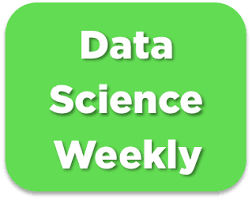

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [60]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# Read file with labels

In [61]:
data = pd.read_csv('data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [62]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [63]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [64]:
data_sample.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [65]:
# Basic stats

print("Basics statistics: ")
data_desc = data_sample.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data_sample.isna().sum()/data_sample.shape[0])

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.00000,10000.00000,10000,10000.00000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5593,NaN,NaN,4964,NaN,NaN
mean,NaN,30.60950,0.68530,NaN,4.85190,0.029100
std,NaN,8.25976,0.46442,NaN,3.27546,0.168095
min,NaN,17.00000,0.00000,NaN,1.00000,0.000000
25%,NaN,24.00000,0.00000,NaN,2.00000,0.000000
50%,NaN,30.00000,1.00000,NaN,4.00000,0.000000
75%,NaN,36.00000,1.00000,NaN,7.00000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [66]:
data_sample['converted'].value_counts(normalize=True)

0    0.9709
1    0.0291
Name: converted, dtype: float64

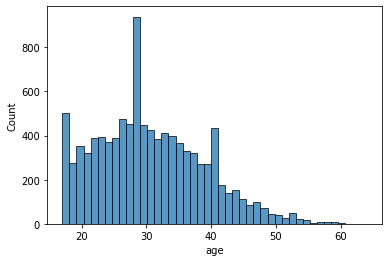

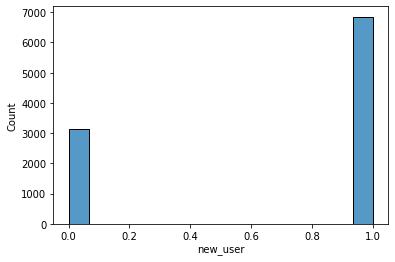

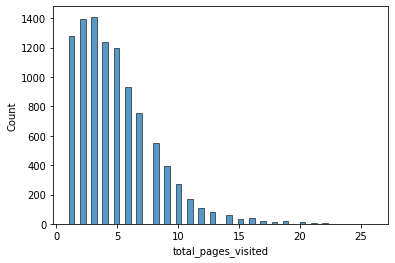

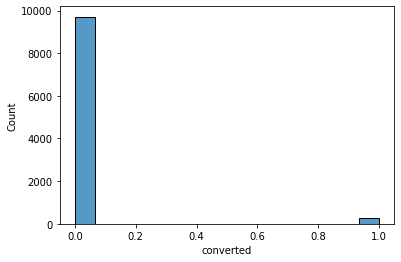

In [67]:
for col in data_sample.select_dtypes('int'):
    plt.figure()
    sns.histplot(data_sample[col])

<AxesSubplot:xlabel='age'>

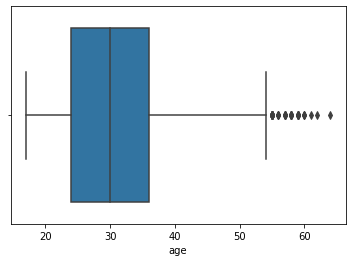

In [68]:
sns.boxplot(data=data_sample, x='age')

75 % of the visitors are under 35 years old

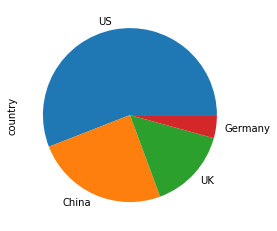

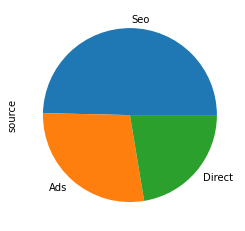

In [69]:
for col in data_sample.select_dtypes('object'):
    plt.figure()
    data_sample[col].value_counts().plot.pie()

In [70]:
positive_data_sample = data_sample[data_sample['converted'] == 1]
negative_data_sample = data_sample[data_sample['converted'] == 0]

In [71]:
data_sample.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [72]:
numerical_columns = ['age', 'total_pages_visited']
categorical_columns = ['country', 'source', 'new_user']

c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level

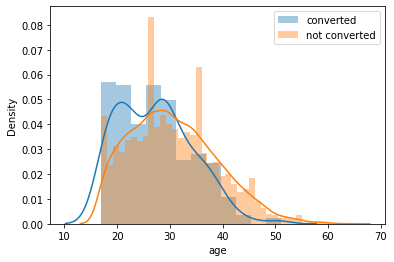

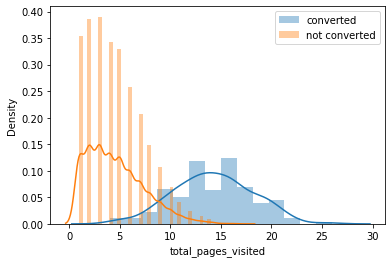

In [73]:
for col in numerical_columns:
    plt.figure()
    sns.distplot(positive_data_sample[col], label='converted')
    sns.distplot(negative_data_sample[col], label='not converted')
    plt.legend()

These plots shows that youger users are slightly more likely to be converted and that as users visit more pages, the probability of conversion increases.

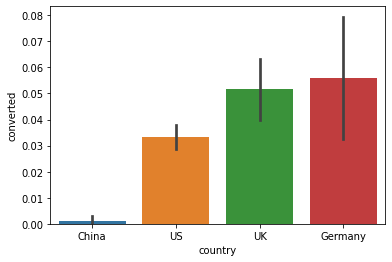

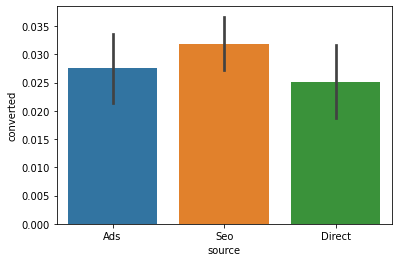

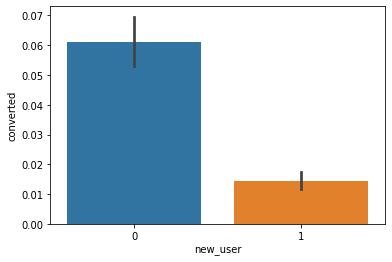

In [74]:
for col in categorical_columns:
    plt.figure()
    sns.barplot(data=data_sample, x=col, y='converted')

The chinese users are significantly more likely to not be converted compared to users from other countries.

Most people are comming from ads, then from Seo, then from direct source.

New users are not really conviced even if they are more numerous than previous users !

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

baseline accuracy : 

In [116]:
1-sum(data['converted'])/len(data['converted'])

0.967741935483871

In [75]:
features_list = ['total_pages_visited']
target_variable = 'converted'

In [76]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [77]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [78]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[2]
 [2]
 [7]
 [3]
 [8]]
[[14]
 [ 5]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [79]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.85939501]
 [-0.85939501]
 [ 0.63639894]
 [-0.56023622]
 [ 0.93555773]]


In [80]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [81]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [82]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 2.73051047]
 [ 0.03808136]
 [-0.26107743]
 [ 0.93555773]
 [-0.85939501]]


In [83]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1 0 0 ... 0 0 0]



## Performance assessment

In [84]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6971029668411867
f1-score on test set :  0.6771951989892608


In [85]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246790   1070]
 [  3269   4993]]

Confusion matrix on test set : 
[[27411   129]
 [  382   536]]



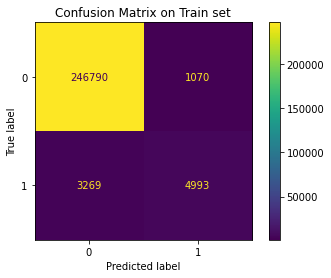

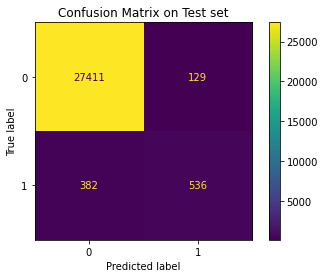

In [86]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

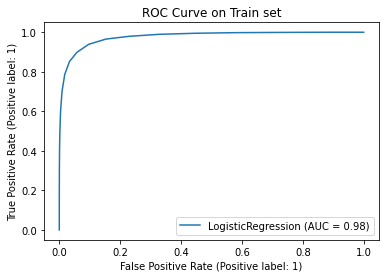

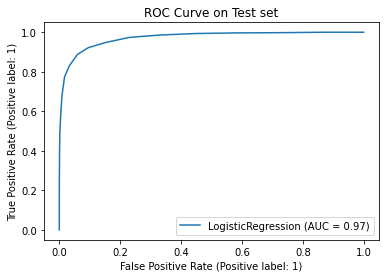

In [87]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [88]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [89]:
# Read data without labels
data_without_labels = pd.read_csv('data/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [90]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32882805]
 [ 0.03808136]
 [-1.1585538 ]
 [ 0.33724015]
 [-0.56023622]]


In [91]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
prediction_data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=prediction_data)
Y_predictions.to_csv('conversion_data_test_predictions_BAPTISTE-model1.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

### Multivariate logistic regression

In [92]:
# let's train a multivariate model by adding more variables to the feature list

features_list =['total_pages_visited', 'age', 'country', 'source', 'new_user']

numerical_features = ['total_pages_visited', 'age']
categorical_features = ['country', 'source', 'new_user']

target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'source', 'new_user'], dtype='object')



In [93]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [94]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [95]:
print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

print("Preprocessing X_test...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:]) # X_test is now a numpy array


Preprocessing X_train...

...Done!
[[-0.85939501 -0.91458053  0.          0.          0.          1.
   0.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.
   0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          0.
   1.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          0.
   1.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          0.
   0.          1.        ]]

Preprocessing X_test...
...Done
[[ 2.73051047 -0.79365434  0.          0.          0.          0.
   0.          1.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          1.
   0.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          1.
   0.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          0.
   1.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1.          0.
   1.          1.        ]]


In [96]:
print("Convert pandas DataFrames to numpy arrays...")
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[0 0 0 0 0]
[0 0]


In [97]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [98]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [99]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [100]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7640283915896611
f1-score on test set :  0.7595396729254997


In [101]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246893    967]
 [  2557   5705]]

Confusion matrix on test set : 
[[27434   106]
 [  291   627]]



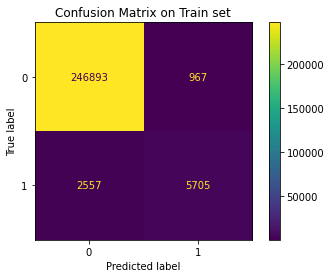

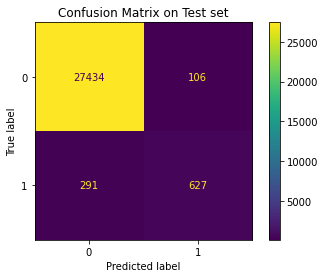

In [102]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

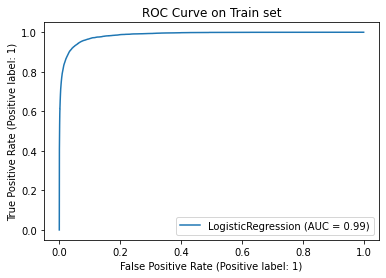

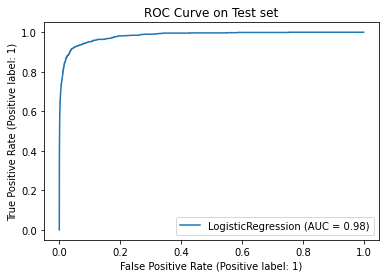

In [103]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

Submission

In [115]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)
# Read data without labels
data_without_labels = pd.read_csv('data/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited', 'age', 'country', 'source', 'new_user']
X_without_labels = data_without_labels.loc[:, features_list]

# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
prediction_data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=prediction_data)
Y_predictions.to_csv('conversion_data_test_predictions_BAPTISTE-model2.csv', index=False)



Prediction set (without labels) : (31620, 5)
Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32882805 -0.30994956  0.          1.          0.          0.
   1.          0.        ]
 [ 0.03808136 -1.03550673  0.          1.          0.          1.
   0.          1.        ]
 [-1.1585538   0.17375521  0.          0.          0.          0.
   1.          1.        ]
 [ 0.33724015  0.17375521  0.          0.          1.          0.
   0.          1.        ]
 [-0.56023622 -0.67272814  0.          0.          0.          0.
   1.          0.        ]]


Feature importance

In [104]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['total_pages_visited', 'age', 'country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo', 'new_user_1']


In [105]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = classifier.coef_.transpose(), columns=["coefficients"])
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients', ascending = False)
feature_importance

,coefficients
country_Germany,3.628772
country_UK,3.428973
country_US,3.073296
total_pages_visited,2.548017
new_user_1,1.719925
age,0.603111
source_Direct,0.207835
source_Seo,0.043578


Text(0.5, 0, 'Logistic regression feature importance')

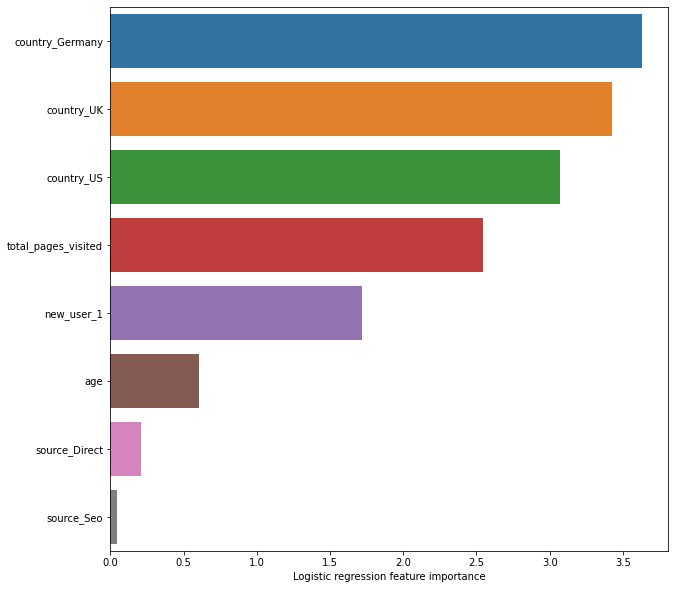

In [106]:
plt.figure(figsize=(10, 10))
sns.barplot(y = feature_importance.index, x = feature_importance['coefficients'])
plt.xlabel("Logistic regression feature importance")

The most important feature is *country*. The 2nd most important feature is *total_pages_visited* : this feature is not really useful for the company since it is difficult to cause people to visit more pages. Let's try to remove *total_pages_visited* from now on.

In [133]:
# remove total_pages_visited from the feature's list

features_list = ['age', 'country', 'source', 'new_user']

numerical_features = ['age']
categorical_features = ['country', 'source', 'new_user']

target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['age', 'country', 'source', 'new_user'], dtype='object')



In [134]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [135]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [136]:
print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

print("Preprocessing X_test...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:]) # X_test is now a numpy array

Preprocessing X_train...

...Done!
[[-0.91458053  0.          0.          0.          1.          0.
   0.        ]
 [-0.30994956  0.          0.          0.          0.          0.
   0.        ]
 [-0.06809718  0.          0.          0.          0.          1.
   1.        ]
 [ 0.77838618  0.          1.          0.          0.          1.
   1.        ]
 [ 0.05282902  0.          0.          1.          0.          0.
   1.        ]]

Preprocessing X_test...
...Done
[[-0.79365434  0.          0.          0.          0.          0.
   1.        ]
 [ 0.53653379  0.          0.          1.          1.          0.
   0.        ]
 [-0.18902337  0.          0.          1.          1.          0.
   0.        ]
 [ 0.05282902  0.          0.          0.          0.          1.
   1.        ]
 [-0.30994956  0.          0.          1.          0.          1.
   1.        ]]


In [137]:
print("Convert pandas DataFrames to numpy arrays...")
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[0 0 0 0 0]
[0 0]


In [138]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [139]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [141]:
# Predictions on training set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



f1-score on train set :  0.0
f1-score on test set :  0.0



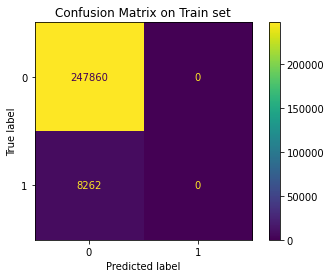

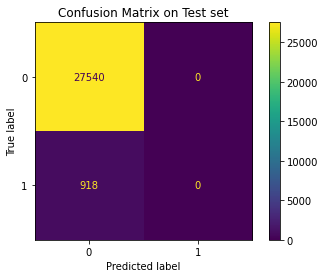

In [142]:
#f1-score
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

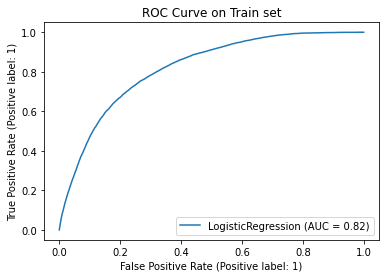

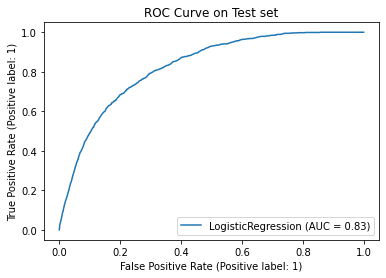

In [146]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

Oups ! we droped the f1-score to 0, it seems that *total_pages_visited* explained all the behaviour of the users

Now we also use the logistic regression model but take into account the two classes proportions : class 1 (converted) is weighted during the learning

In [143]:
classifier = LogisticRegression(class_weight="balanced") # takes into account the different classes' proportions
classifier.fit(X_train, Y_train)
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 1 1 0]

Predictions on test set...
...Done.
[0 1 1 ... 1 0 0]

f1-score on train set :  0.154970869668276
f1-score on test set :  0.1566935392301578


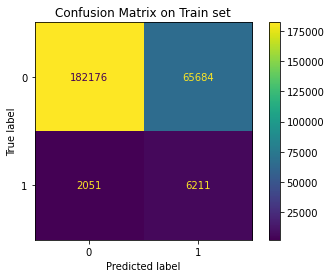

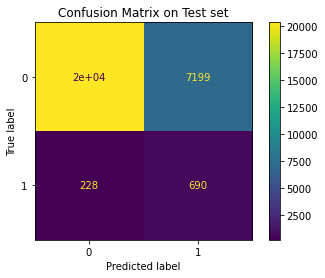

In [144]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Now we make less mistake when predicting the 'converted' class than before BUT our f1 score dropped significantly -> too much False Positives = low Precision.
With this model we will surrestimate greatly the number of real converted users.

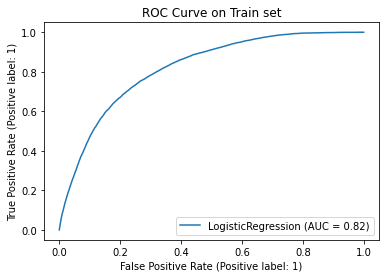

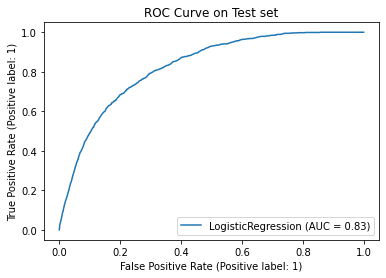

In [145]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

Searching for the best hyperparameters to improve the model

In [ ]:
# reprocessing

features_list =['total_pages_visited', 'age', 'country', 'source', 'new_user']

numerical_features = ['total_pages_visited', 'age']
categorical_features = ['country', 'source', 'new_user']

target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=0)
print("...Done.")
print()
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

print("Preprocessing X_test...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:]) # X_test is now a numpy array

print("Convert pandas DataFrames to numpy arrays...")
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print(Y_train[0:5])
print(Y_test[0:2])

In [50]:
# grid search logistic regression model
# define model
model = LogisticRegression()
# define evaluation
cv = 5
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, Y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


320 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1233, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, pref

Best Score: 0.6970862179754966
Best Hyperparameters: {'C': 1e-05, 'penalty': 'none', 'solver': 'lbfgs'}


The grid search suggest a different solver than default and a ridge penalty with a small regularization strenght

In [133]:
classifier = LogisticRegression(solver='liblinear', penalty='l2', C=10) # takes into account the different classes' proportions
classifier.fit(X_train, Y_train)
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on train set :  0.7643201284796572
f1-score on test set :  0.7590799031476998


Didn't improve our score by much

### Linear SVM

Let's train a linear SVM and evaluate its performances:

In [34]:
print('Training linear SVM...')
svc = SVC(kernel = 'linear', C=10, gamma=100)
svc.fit(X_train, Y_train)
print("...Done.")

Training linear SVM...
...Done.


In [35]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[1 0 0 ... 0 0 0]



In [49]:
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

print("metrics training set")
print(display_metrics(Y_train, Y_train_pred))
print("metrics test set")
print(display_metrics(Y_test, Y_test_pred))

f1-score on training set :  0.6413305354783554
f1-score on test set :  0.6377622377622377
metrics training set


NameError: name 'display_metrics' is not defined

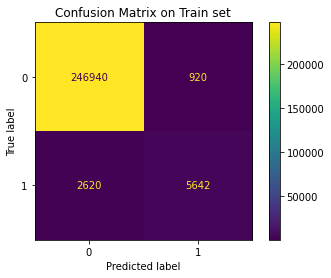

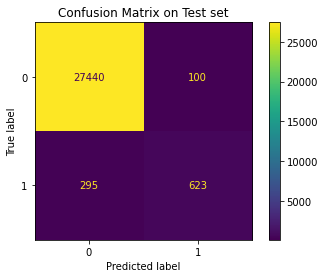

In [81]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

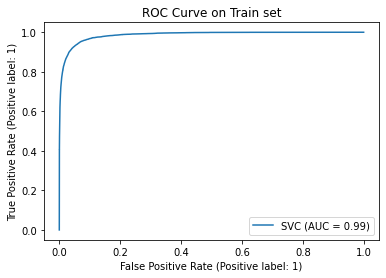

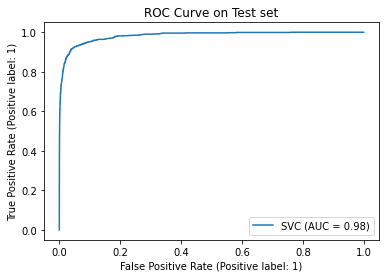

In [138]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(svc, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(svc, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

In [46]:
print('Training linear SVM...')
svc = SGDClassifier(max_iter=1000, alpha=0.0001)
svc.fit(X_train, Y_train)
print("...Done.")

Training linear SVM...
...Done.


In [47]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [48]:
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.6413305354783554
f1-score on test set :  0.6377622377622377


We don't see improvments compared to logistic regression

### Random Forest

Let's train an ensemble model and evaluate its performances:

In [157]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [158]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = forest.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = forest.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [159]:
print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.8029661016949153
f1-score on test set :  0.7350835322195705


In [77]:
print("metrics training set")
print(display_metrics(Y_train, Y_train_pred))
print("metrics test set")
print(display_metrics(Y_test, Y_test_pred))

metrics training set
f1-score:  0.761198057204533
precision:  0.8597988418165193
recall:  0.682885499878964
acuracy:  0.9861784618267857
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247860
           1       0.86      0.68      0.76      8262

    accuracy                           0.99    256122
   macro avg       0.92      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

None
metrics test set
f1-score:  0.7592931139549056
precision:  0.8616874135546335
recall:  0.6786492374727668
acuracy:  0.9861198959870686
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27540
           1       0.86      0.68      0.76       918

    accuracy                           0.99     28458
   macro avg       0.93      0.84      0.88     28458
weighted avg       0.99      0.99      0.99     28458

None


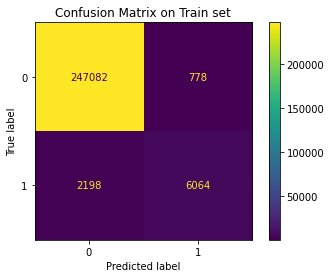

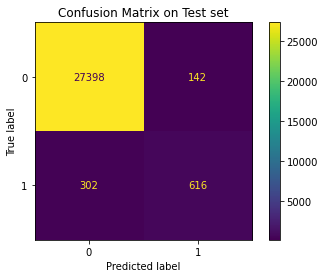

In [160]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(forest, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(forest, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Feature importance

In [58]:
column_names

NameError: name 'column_names' is not defined

In [178]:
np.array([1, 2, 3])[:: -1]

array([3, 2, 1])

In [179]:
sorted_idx = forest.feature_importances_.argsort()[::-1]
sorted_idx

array([0, 1, 7, 4, 3, 2, 6, 5], dtype=int64)

In [180]:
forest.feature_importances_

array([0.81370804, 0.10450603, 0.0079839 , 0.01237783, 0.01370874,
       0.00398664, 0.00438249, 0.03934633])

Text(0.5, 0, 'Random forest feature importance')

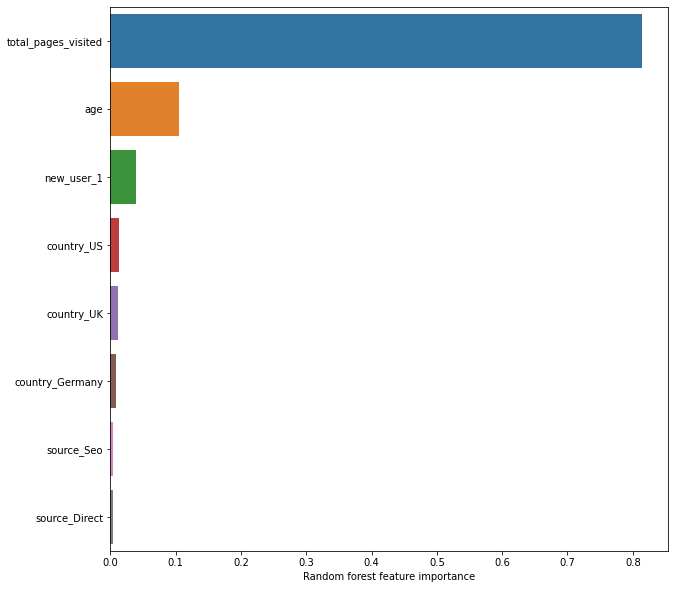

In [181]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = forest.feature_importances_.argsort()[::-1]
sns.barplot(y = np.array(column_names)[sorted_idx], x = forest.feature_importances_[sorted_idx])
plt.xlabel("Random forest feature importance")

Grid search CV for random forest

In [28]:
###### Training with hyperparameters optimization #######

# ⚠ code execution time ~ 30min

# Perform grid search
print("Grid search...")
forest_model = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [10, 25, 100],
    'min_samples_leaf': [1, 2, 10],
    'min_samples_split': [4, 8, 12],
    'n_estimators': [50, 100, 300]
}

gridsearch = GridSearchCV(forest_model, scoring='f1', param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best f1-score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 12, 'n_estimators': 300}
Best validation accuracy :  0.7590709831151974


In [107]:
forest = RandomForestClassifier(max_depth= 10, min_samples_leaf= 10, min_samples_split= 12, n_estimators= 300, random_state=42)
forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=12,
                       n_estimators=300, random_state=42)

In [108]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = forest.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = forest.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



metrics training set
f1-score:  0.7715606781478256
precision:  0.8642846419456538
recall:  0.6968046477850399
acuracy:  0.9866899368269809
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247860
           1       0.86      0.70      0.77      8262

    accuracy                           0.99    256122
   macro avg       0.93      0.85      0.88    256122
weighted avg       0.99      0.99      0.99    256122

None
metrics test set
f1-score:  0.7576668671076366
precision:  0.8456375838926175
recall:  0.6862745098039216
acuracy:  0.985838779956427
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27540
           1       0.85      0.69      0.76       918

    accuracy                           0.99     28458
   macro avg       0.92      0.84      0.88     28458
weighted avg       0.98      0.99      0.99     28458

None


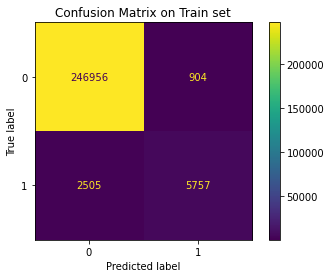

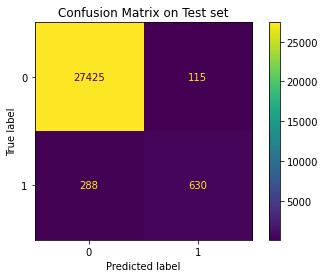

In [109]:
# display metrics
def display_metrics(true, pred):
    print("f1-score: ", metrics.f1_score(true, pred))
    print("precision: ", metrics.precision_score(true, pred))
    print("recall: ", metrics.recall_score(true, pred))
    print("acuracy: ", metrics.accuracy_score(true, pred))
    print(metrics.classification_report(true, pred))


print("metrics training set")
print(display_metrics(Y_train, Y_train_pred))
print("metrics test set")
print(display_metrics(Y_test, Y_test_pred))

# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(forest, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(forest, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

We obtain the same f1-score with logisitic regression and random forest

Text(0.5, 0, 'Random forest feature importance')

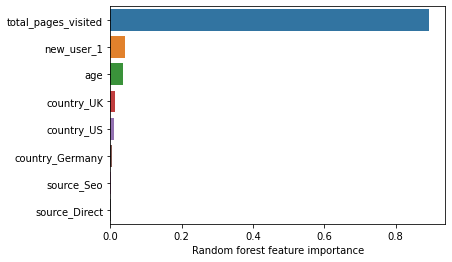

In [111]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = forest.feature_importances_.argsort()[::-1]
sns.barplot(y = np.array(column_names)[sorted_idx], x = forest.feature_importances_[sorted_idx])
plt.xlabel("Random forest feature importance")

With the regularized random forest classifier, we obtain a new feature importance order.

## **Recommandations**

How the website can improve its conversion rate ?

- The most important feature is the number of pages visited. You can't really enhance the user's own interest and we can say that people visiting more pages are already conviced by the newsettler anyway. Maybe a better user interface will encourage people to dig more into the website.

- The 2nd most important feature is whether or not it is the first time the user visit the website. The site must encourage their older user to come back.

- Users from China have a very poor conversion rate. A lot of visitors come from China, therefore the website must come up with features that appeal to these users. Maybe the interface is not adapted to them and there is a translation problem that need to be investigated.

- Younger user (less than 35) represent the majority of people that subscribe to the newsettler. The site must target this population with cutomized adds to maximize their conversion rate.

Submission